# 목차

* 데이터 전처리
* 하이퍼 파라미터 조정
* 결과 제출하고 스코어 확인
* Reference
* 회고
-------------------------
## 루브릭 평가기준

1. 캐글 데이터분석 전과정이 성공적으로 진행되었는가?  
데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 만든 csv파일을 캐글 My submission까지 진행했고, submission 결과를 이미지로 제출하였다.

2. 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?  
제출한 주피터노트북 파일이 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.

3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가?  
다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 시각화 그래프가 나타날 수 있도록

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [34]:
# 필요한 라이브러리 가져오기

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 전처리

In [35]:
data_dir = '/content/drive/MyDrive/아이펠 데이터/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(test_data_path)

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

/content/drive/MyDrive/아이펠 데이터/kaggle_kakr_housing/data/train.csv
/content/drive/MyDrive/아이펠 데이터/kaggle_kakr_housing/data/test.csv


In [36]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [37]:
# date열을 년도와 월로 분리함.

train['year'] = train['date'].apply(lambda i: i[:4]).astype(int)
train['month'] = train['date'].apply(lambda i: i[4:6]).astype(int)

del train['date']

train.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month
0,0,221900.0,3,1.00,1180,5650,1.0,0,0,3,...,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10
1,1,180000.0,2,1.00,770,10000,1.0,0,0,3,...,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2
2,2,510000.0,3,2.00,1680,8080,1.0,0,0,3,...,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2
3,3,257500.0,3,2.25,1715,6819,2.0,0,0,3,...,0,1995,0,98003,47.3097,-122.327,2238,6819,2014,6
4,4,291850.0,3,1.50,1060,9711,1.0,0,0,3,...,0,1963,0,98198,47.4095,-122.315,1650,9711,2015,1


기존의 date열은 지나치게 길 뿐더러 년도와 월이 합쳐져 있었다. 그러나 시간은 10진법으로 쓰이지 않기 때문에 이것을 하나의 수로 표현하는 것보다 분리하는 것이 더 좋은 방법으로 보였다.  
이렇게 함으로써 시간의 흐름을 보다 명확하게 표현할 수 있을 것이다.

In [38]:
# 타겟 데이터 분리

y = train['price']
del train['price']

# id 컬럼 삭제

del train['id']

print(train.columns)

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year', 'month'],
      dtype='object')


In [39]:
# 타겟데이터에도 적용

test['year'] = test['date'].apply(lambda i: i[:4]).astype(int)
test['month'] = test['date'].apply(lambda i: i[4:6]).astype(int)

del test['date']
del test['id']

test

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month
0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12
1,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12
2,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930,2014,5
3,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113,2015,4
4,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570,2015,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303,2014,6
6464,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230,2015,1
6465,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265,2015,2
6466,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,2014,6


In [40]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

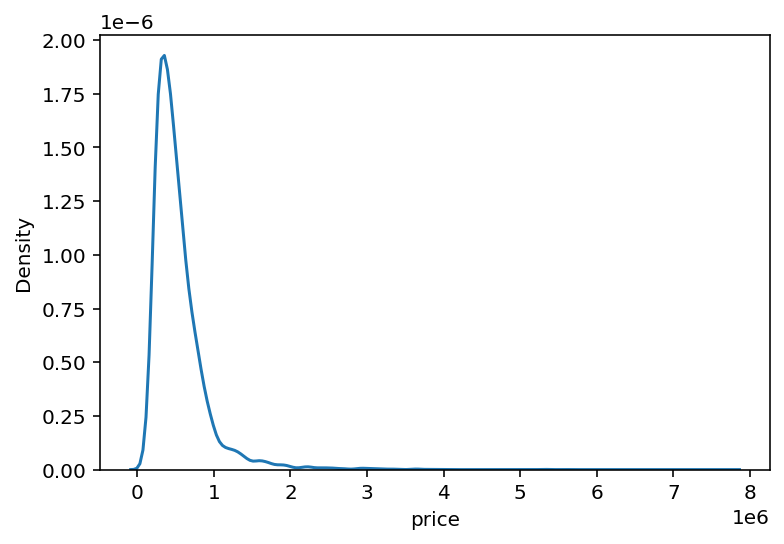

In [41]:
sns.kdeplot(y)
plt.show()

In [42]:
# 너무 한 쪽에 치우쳐져 있으므로 로그변환
# 로그변환/나중에 np.expm1() 으로 복구

y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

이곳에서 로그변환을 통해 값을 퍼뜨리는 작업을 하는데 이후 다시 복구하는 것을 잊어선 안 된다.

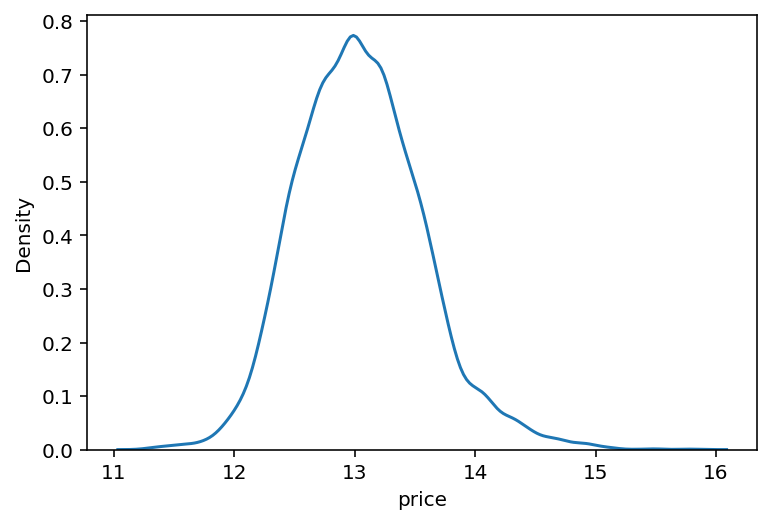

In [43]:
sns.kdeplot(y)
plt.show()

In [44]:
train.info() # 모든 데이터가 실수,정수이므로 모델에 사용 가능

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       15035 non-null  int64  
 1   bathrooms      15035 non-null  float64
 2   sqft_living    15035 non-null  int64  
 3   sqft_lot       15035 non-null  int64  
 4   floors         15035 non-null  float64
 5   waterfront     15035 non-null  int64  
 6   view           15035 non-null  int64  
 7   condition      15035 non-null  int64  
 8   grade          15035 non-null  int64  
 9   sqft_above     15035 non-null  int64  
 10  sqft_basement  15035 non-null  int64  
 11  yr_built       15035 non-null  int64  
 12  yr_renovated   15035 non-null  int64  
 13  zipcode        15035 non-null  int64  
 14  lat            15035 non-null  float64
 15  long           15035 non-null  float64
 16  sqft_living15  15035 non-null  int64  
 17  sqft_lot15     15035 non-null  int64  
 18  year  

In [45]:
# 필요한 함수 생성
# 오차를 구할 함수 2개

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# np.log1p 를 썼으므로 expm1 사용

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# 4개 모델 임포팅

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [46]:
random_state=2020 # 랜덤스테이트 설정
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [47]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

[05:12:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE
XGBRegressor,130473.506835
GradientBoostingRegressor,129856.419070
RandomForestRegressor,125536.800803
LGBMRegressor,112049.198779


비교해본 결과 4개의 모델 중 LGBMRegressor가 가장 성능이 좋다는 사실을 알 수 있었다.  
따라서 이 모델을 가지고 학습 및 테스트를 진행한다.

# 하이퍼 파라미터 조정

In [48]:
# 하이퍼 파라미터 튜닝하기
# 그리드 탐색

from sklearn.model_selection import GridSearchCV

In [49]:
# 하이퍼 파라미터1

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [50]:
model = LGBMRegressor(random_state=random_state)

In [51]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [52]:
grid_model.cv_results_

# 데이터가 너무 많으므로 원하는 값만 보자.
# 파라미터 조합은 params 에, 각 테스트 점수는 mean_test_score 에 저장되어있음

{'mean_fit_time': array([0.29843855, 0.45694652, 1.02780309, 1.61997356]),
 'std_fit_time': array([0.03659735, 0.06647633, 0.0513514 , 0.04004031]),
 'mean_score_time': array([0.02958832, 0.03550186, 0.06168361, 0.05412064]),
 'std_score_time': array([0.00355567, 0.01404527, 0.02649721, 0.02229466]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02900282, -0.02684007]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.0304264 , -0.02801938]),
 'split2_test_score': array([-0.07354904

In [53]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [54]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02940402, -0.02717394])

In [55]:
# 위 두 결과를 합쳐서 데이터 프레임으로 만듦

results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029404
3,10,100,-0.027174


In [56]:
# GridSearchCV 에서 우리는 neg_mean_squared_error 를 사용했다.
# 그러므로 -1을 곱하고 루트를 씌워서 RMSE 로 만든다.

results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029404,0.171476
3,10,100,-0.027174,0.164845


In [57]:
# Root Mean Squared Log Error 사실 price 가 아직 로그값이다.

results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029404,0.171476
3,10,100,-0.027174,0.164845


In [58]:
# RMSLE 순서로 정렬

results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027174,0.164845
2,10,50,-0.029404,0.171476
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [59]:
# 위의 과정을 함수화

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [60]:
# 가장 좋은 파라미터가 무엇인지 확인

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10] 
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027174,0.164845
2,10,50,-0.029404,0.171476
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [61]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.09620474, 13.07084325, 14.21470283, ..., 13.0277126 ,
       12.69143596, 12.97886166])

위 결과를 통해 두 파라미터가 클수록 성능이 좋아진다는 점을 알 수 있다.

# 결과 제출하고 점수 확인하기

In [62]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction) # 위의 결과물이 로그 결과물이므로 다시 변환
    data_dir = '/content/drive/MyDrive/아이펠 데이터/kaggle_kakr_housing/data' # 디렉토리 확인할 것
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [63]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.1648')

/content/drive/MyDrive/아이펠 데이터/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.1648.csv saved!


이렇게 해서 얻은 점수는 114611.88176 이다.

모델을 조금 더 손 봐서 이것을 낮춰보자.

In [64]:
param_grid = {
    'n_estimators': [200],
    'max_depth': [30, -1],
    'booting_type':['rf', 'gbdt', 'dart'] 
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


,booting_type,max_depth,n_estimators,score,RMSLE
0,rf,30,200,-0.026343,0.162307
1,rf,-1,200,-0.026343,0.162307
2,gbdt,30,200,-0.026343,0.162307
3,gbdt,-1,200,-0.026343,0.162307
4,dart,30,200,-0.026343,0.162307
5,dart,-1,200,-0.026343,0.162307


부스팅 타입에 상관없이 같은 성능을 보이며 mat_depth도 30이면 충분히 많은 것으로 보인다. 

In [65]:
model = LGBMRegressor(max_depth=30, n_estimators=200, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.1357205 , 13.1036669 , 14.15048874, ..., 13.04793565,
       12.71866146, 12.99881524])

In [66]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.1623')

/content/drive/MyDrive/아이펠 데이터/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.1623.csv saved!


그 결과는 113541.06830 이었다. 파라미터를 바꾼 것은 효과가 있었다.

이번에는 파라미터가 아닌 예측 방법을 바꾸어 애버리지 블렌딩 모델을 사용해보기로 했다.

In [67]:
# 3개의 모델 사용

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = xgb.XGBRegressor(random_state=random_state)
lightgbm = lgb.LGBMRegressor(random_state=random_state)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [68]:
# 교차 검증/모델의 성능 간단히 평가하는 함수

def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(train.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=train.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [69]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8792
[05:14:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:14:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:14:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:14:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:14:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model: XGBoost, CV score:0.8779
Model: LightGBM, CV score:0.9023


In [70]:
# 애버리지 블렌딩 모델

def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)


In [71]:
y_pred = AveragingBlending(models, train, y, test)
y_pred = np.expm1(y_pred)
print(len(y_pred))
y_pred

[05:14:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
6468


array([ 536170.38203243,  401637.80414167, 1319548.60603804, ...,
        440380.59759977,  343560.46434112,  428433.67951024])

In [72]:
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [73]:
result = pd.DataFrame({
    'id' : submission['id'], 
    'price' : y_pred
})

result.tail()

,id,price
6463,21498,235720.356210
6464,21499,429180.649845
6465,21500,440380.597600
6466,21501,343560.464341
6467,21502,428433.679510


In [74]:
# 위 결과를 서브미션 파일에 저장

my_submission_path = join(data_dir, 'submission_ab.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/content/drive/MyDrive/아이펠 데이터/kaggle_kakr_housing/data/submission_ab.csv


그리고 그 결과 126804.29384 의 점수가 나왔다.

오히려 결과가 더 나빠졌다. 이것은 그리 좋은 방법이 아닌 듯 하다.

그 이유는 간단한데 위에서 이미 확인 했듯이 여러 모델 중 LGBMRegressor가 이번 데이터에서 가장 효과가 좋았기 때문이다. 따라서 각각의 모델로 얻은 결과를 평균을 내는 애버리지 블렌딩 기법을 사용했을 때 오히려 오차가 커지는 결과를 낸다.

In [82]:
# 마지막으로 앞서 조금이나마 성능이 향상된 방법을 극단적으로 쓴다.

model = LGBMRegressor(max_depth=300, n_estimators=2000, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.1551713 , 13.11298768, 14.07189272, ..., 13.12118864,
       12.72885517, 13.0307355 ])

In [83]:
save_submission(model, train, y, test, 'lgbm', rmsle='?')

# 점수는 111681.20175 점

/content/drive/MyDrive/아이펠 데이터/kaggle_kakr_housing/data/submission_lgbm_RMSLE_?.csv saved!


위에서 max_depth가 30과 -1이 별 차이가 없다는 점을 확인했으므로 n_estimators값이 정확도에 영향을 주었음을 알 수 있다.

## 결과

* LGBMRegressor(max_depth=10, n_estimators=100)  
  * 114611점
* Average Blending
  * 126804점
* LGBMRegressor(max_depth=300, n_estimators=2000)
  * 111681점

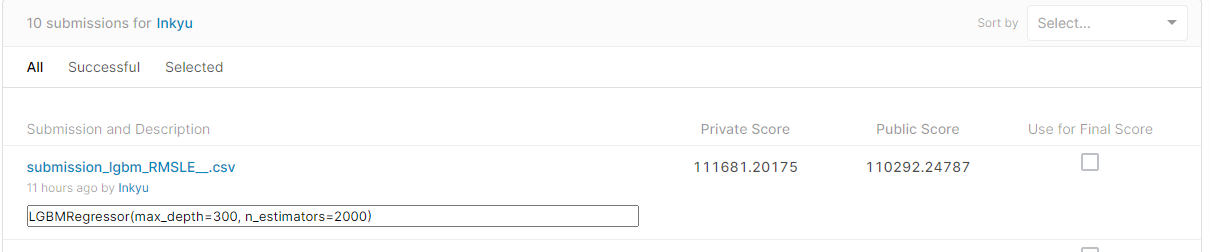


# Reference

http://machinelearningkorea.com/2019/09/29/lightgbm-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0/  
https://injo.tistory.com/48  
https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/

# 회고

이번 실습에서 나는 집의 여러 조건들을 보고 가격을 예측하는 모델을 만들었다. 여러 모델을 비교하자 LGBMRegressor 가장 적합한 모델임을 확인했으며 따라서 이것을 사용했다.

모델의 성능을 향상 시키기 위해 가장 중요한 것은 두 가지였는데 첫째는 데이터를 전처리하여 더 효율적으로 모델이 학습할 수 있도록 하는 것이었고 둘째는 하이퍼 파라미터 조정을 통해 더 나은 파라미터를 찾아내어 적용하는 것이었다. 이를 위해 그리드 탐색을 써서 어떤 값이 더 나은지 비교하는 과정을 지났다.

데이터 전처리에서 불필요한 컬럼을 찾아내어 없앨 수도 있지만 어떤 컬럼이 필요가 없는지 알기 힘들다. 그리고 만약 그런 컬럼이 있다면 학습 과정에서 그 열에 해당하는 매개변수가 작아지고, 자연스럽게 영향력이 낮아질 것이다. 따라서 모델의 정확도에는 큰 변화가 없으리라 예상했기 때문에 그 부분은 넘어갔다.

대신 date 컬럼을 바꿔주었는데 우선 우리에게 중요한 것은 앞의 6자 뿐이었으며, 이것 또한 년도+월로 표현되는 값이었다. 즉 앞의 4자는 10진법인데 뒤의 2자는 12진법이므로 둘을 분리할 필요가 있다고 생각했다. 그래서 하나의 date열을 year, month 두 개의 열로 나누어 따로 적용했다. 그렇게 하면 모델이 학습을 할 때 시간에 대해서 마치 사람이 직관적으로 받아들이는 것처럼 학습할 수 있을 것이라 생각했다.

이렇게 모델을 적용한 결과 실제로 기존보다 캐글 점수가 낮게 나오면서 모델의 정확도가 더 높아짐을 확인할 수 있었다. 그러나 하이퍼 파라미터를 바꿀 때 디폴트 값에 비해 그리 크게 정확도가 높아지지 않았기 때문에 여기서 성능을 더 향상 시키기 위해서는 더 적합한 모델을 사용하는 것이 좋아보였다. 애버리지 블렌딩 과정에서 보았듯이 다른 모델로 완전히 대체한 것도 아님에도 불구하고 정확도가 크게 낮아짐을 볼 수 있었다. 비록 내가 테스트한 모델 가운데선 LGBMRegressor가 가장 나았지만 훨씬 더 정확한 모델이 존재할 수도 있기 때문에 만약 그런 모델을 찾아서 사용했다면 점수가 크게 달라졌으리라 예상한다.

하이퍼 파라미터를 적용할 때 n_estimators의 값이 늘어날 때마다 점수에 영향이 있어서 이 값을 아주 크게 넣어서 적용해보았었다. 그러나 얼마 가지 않아 이 방법으론 정확도 상승에 한계가 금방 찾아왔다. 심지어 값이 늘어남에 따라 오히려 점수가 증가하기까지 했는데 이는 과적합의 문제로 보인다. 일반적으로 정확도를 상승시키는 파라미터라 할지라도 일정 수준 이상으로까지 정확도를 올려주지는 않으며 과할 경우 오히려 모델이 망가질 수도 있다는 사실을 깨달았다.